# Analyse the results of the diffusion output

### Import Libraries

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F

### Load data

In [26]:
#load data from diffusion outputs
cwd = os.getcwd()
diffusion_model_output_path = f'{cwd}/improved-diffusion/out_gen/input_for_analysis3.json'
emotionpath = f'{cwd}/improved-diffusion/out_gen/target_emotion_scores_for_analysis.json'
output_list = []
emotionlist = []
# read in json file
with open(diffusion_model_output_path, 'r') as roc_reader:
    for outp in roc_reader:
        story = json.loads(outp)[0].strip()
        output_list.append(story)
# load the emotion labels
with open(emotionpath, 'r') as emotion_reader:
    for emotion in emotion_reader:
        emotion = json.loads(emotion)
        emotionlist.append(emotion)
print(f'{output_list[:2]}')
print(f'{len(output_list)} stories loaded')
print(f'{len(emotionlist)} emotions loaded')
# convert emotionlist to torch tensor
emotionlist = torch.Tensor(emotionlist)

["A was Wilma his Devin good who Little bear , work suddenly UNK and The 500 They bar rang treats UNK , 's the player ? said sound over for Charles Toby Rick owned Jillian went Warren orchard see out after announced the lunch Polly to asked if he can Once Rick proudly after Walter Once a food fifty saw Billy", "My babysitter was not asked to and UNK two judge records arts We a find to flip the at much that our friend mine UNK He was happy buy job the we said and Ron aced karaoke He offer now 're pumpkin different and from Zoey head instructions on order of stealing Ron He you day despite to have an 's"]
1024 stories loaded
1024 emotions loaded
["A was Wilma his Devin good who Little bear , work suddenly UNK and The 500 They bar rang treats UNK , 's the player ? said sound over for Charles Toby Rick owned Jillian went Warren orchard see out after announced the lunch Polly to asked if he can Once Rick proudly after Walter Once a food fifty saw Billy", "My babysitter was not asked to and 

#### Get specific emotion

In [27]:
print(f'emotionlist.shape: {emotionlist.shape}')
testemo = [0,0,1,0]
testemo = torch.Tensor(testemo)
# emotionlist = testemo.unsqueeze(0).repeat(emotionlist.shape[0], 1)
print(f'emotionlist: {emotionlist[:5]}')

emotionlist.shape: torch.Size([1024, 4])
emotionlist: tensor([[0.0106, 0.9598, 0.0180, 0.0117],
        [0.3256, 0.0217, 0.0924, 0.5603],
        [0.0965, 0.0325, 0.0153, 0.8557],
        [0.1019, 0.4786, 0.2782, 0.1413],
        [0.1165, 0.3645, 0.3397, 0.1794]])


In [28]:
# emotion labels are
labels= ['anger', 'joy', 'optimism', 'sadness']

## Get classification

In [29]:
# !pip install transformers
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
import torch
import csv
import urllib.request
import json
import re
import os


class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """

    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32,
                              np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []

    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary


task = 'emotion'
dataset = 'valid'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
splitsentences = False
printresults = False
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels = []
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"

with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]
print(f"labels: {labels}")


# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
tokenizer.save_pretrained(MODEL)
model.save_pretrained(MODEL)
pytorch_total_params = sum(p.numel() for p in model.parameters())

print(f'the parameter count is {pytorch_total_params}')
# check if cuda is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model.to(device)


textarr = output_list
scoresarray =  0
# get scores
loopstodo = len(textarr)
print(f"Looping through: ")
for text in textarr:
    loopstodo = loopstodo-1
    print(f'{loopstodo}        ', end='\r')
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    encoded_input.to(device)
    output = model(**encoded_input)[0][0].cpu()
    scores = output.detach().numpy()
    scores = torch.Tensor(scores)
    scores = torch.nn.Softmax(dim=-1)(scores)
    if type(scoresarray) == int:
        scoresarray = scores
        scoresarray.resize_(1, scores.shape[0])
    else:
        scores.resize_(1, scores.shape[0])
        scoresarray = torch.cat((scoresarray, scores), dim=0)
        


bert_emotion_list = scoresarray
print(f'bert_emotion_list.shape: {bert_emotion_list.shape}')
print(f'emotionlist.shape: {emotionlist.shape}')
print(f'bert_emotion_list[:10]: {bert_emotion_list[:10]}')

labels: ['anger', 'joy', 'optimism', 'sadness']
the parameter count is 124648708
Looping through: 
bert_emotion_list.shape: torch.Size([1024, 4])
emotionlist.shape: torch.Size([1024, 4])
bert_emotion_list[:10]: tensor([[0.0317, 0.8670, 0.0446, 0.0567],
        [0.1984, 0.3436, 0.0405, 0.4175],
        [0.4014, 0.0109, 0.0150, 0.5727],
        [0.0456, 0.7227, 0.0632, 0.1685],
        [0.1088, 0.4416, 0.0364, 0.4131],
        [0.2679, 0.0734, 0.1235, 0.5352],
        [0.0575, 0.8063, 0.0258, 0.1103],
        [0.1521, 0.0575, 0.1255, 0.6648],
        [0.1277, 0.6950, 0.0569, 0.1204],
        [0.0934, 0.7211, 0.1135, 0.0720]])


## Get random emotion labels

In [30]:
# pick random seed for reproducibility
# seed = 31
# load the emotion labels
pathtorandemos = f'{cwd}/datasets/ROCstory/roc_train_emotion_split_True_scores.json'
rand_emotionlist_orig = []
with open(pathtorandemos, 'r') as rr:
    for emotion in rr:
        emotion = json.loads(emotion)
        rand_emotionlist_orig.append(emotion)
# print the first two emotions
print(f'{rand_emotionlist_orig[:2]}')

rand_indices = np.random.randint(0, len(rand_emotionlist_orig), emotionlist.shape[0])
# shuffle the indices
np.random.shuffle(rand_indices)
rand_emotionlist_ = [rand_emotionlist_orig[i] for i in rand_indices]
rand_emotionlist_ = torch.Tensor(rand_emotionlist_)

rand_indices_b = np.random.randint(0, len(rand_emotionlist_orig), emotionlist.shape[0])
rand_emotionlist_b = [rand_emotionlist_orig[i] for i in rand_indices_b]
rand_emotionlist_b = torch.Tensor(rand_emotionlist_b)
print(f'rand_emotionlist_.shape: {rand_emotionlist_.shape}')

[[0.11232228577136993, 0.3019600510597229, 0.4512033760547638, 0.13451427221298218], [0.059843190014362335, 0.04509861394762993, 0.07209575921297073, 0.8229624032974243]]
rand_emotionlist_.shape: torch.Size([1024, 4])


## Distribution of target emotions and generated emotions

i: 0
i: 1
i: 2
i: 3


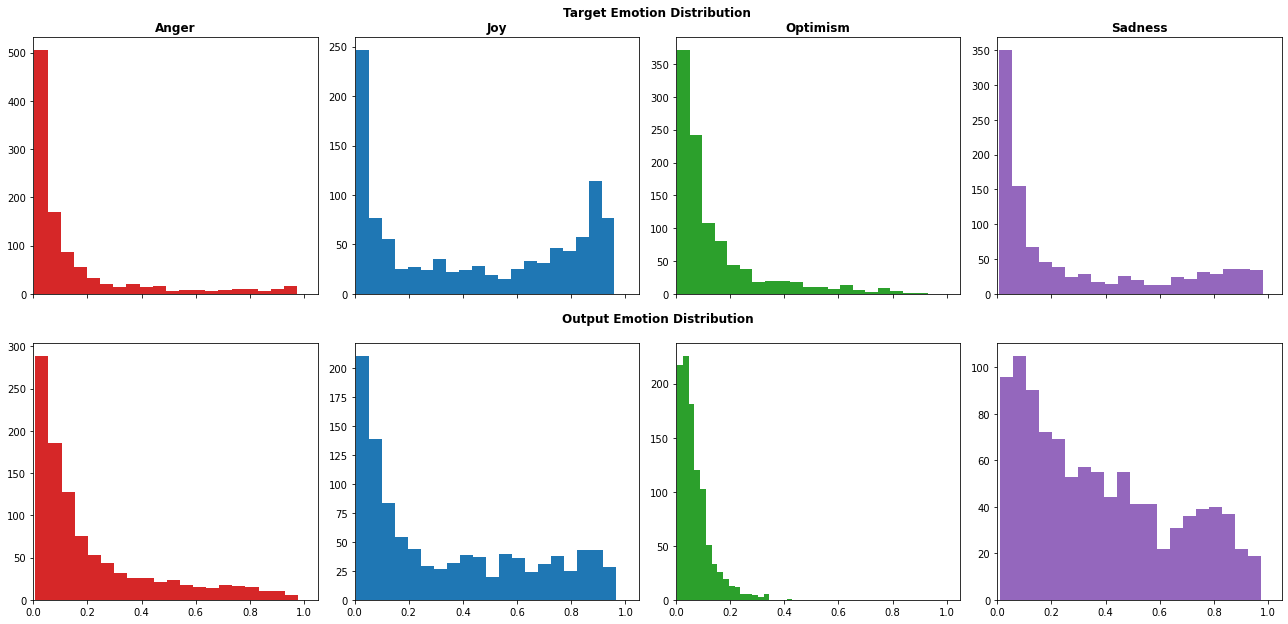

In [31]:
# plot both emotion distributions in bins
anger =  emotionlist.transpose(0,1)[0]
anger_out = bert_emotion_list.transpose(0,1)[0]
joy = emotionlist.transpose(0,1)[1]
joy_out = bert_emotion_list.transpose(0,1)[1]
optimism = emotionlist.transpose(0,1)[2]
optimism_out = bert_emotion_list.transpose(0,1)[2]
sadness = emotionlist.transpose(0,1)[3]
sadness_out = bert_emotion_list.transpose(0,1)[3]


from matplotlib.gridspec import SubplotSpec
# diplay the distribution of each emotion with matplotlib in individual subplots
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    row = fig.add_subplot(grid)
    row.set_title(f'{title}\n', fontweight='semibold')
    row.set_frame_on(False)
    row.axis('off')


rows = 2
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(18, 9), sharex=True)
# set x-axis min and max
xmin = 0
xmax = 1.05
plt.xlim(xmin, xmax)


#set the titles for each subplot
titles = ['Anger', 'Joy', 'Optimism', 'Sadness']

for i, ax in enumerate(axs.flatten()):
    # break if we've reached the end of the list of emotions
    if i >= len(titles):
        break
    print(f'i: {i}')
    ax.set_title(titles[i], fontweight='semibold')
# set the data for each subplot
axs[0, 0].hist(anger, bins=20, color='#d62728')
axs[0, 1].hist(joy, bins=20, color='#1f77b4')
axs[0, 2].hist(optimism, bins=20, color='#2ca02c')
axs[0, 3].hist(sadness, bins=20, color='#9467bd')
axs[1, 0].hist(anger_out, bins=20, color='#d62728')
axs[1, 1].hist(joy_out, bins=20, color='#1f77b4')
axs[1, 2].hist(optimism_out, bins=20, color='#2ca02c')
axs[1, 3].hist(sadness_out, bins=20, color='#9467bd')
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.5)
grid = plt.GridSpec(rows, cols)
create_subtitle(fig, grid[0, ::], 'Target Emotion Distribution')
create_subtitle(fig, grid[1, ::], 'Output Emotion Distribution')
fig.tight_layout()
fig.set_facecolor('w')


i: 0
i: 1
i: 2
i: 3


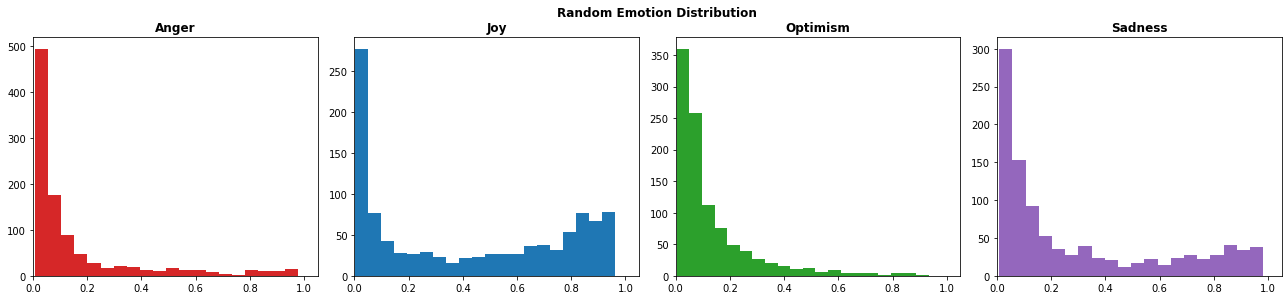

In [32]:
# plot both emotion distributions in bins
anger =  rand_emotionlist_.transpose(0,1)[0]
joy = rand_emotionlist_.transpose(0,1)[1]
optimism = rand_emotionlist_.transpose(0,1)[2]
sadness = rand_emotionlist_.transpose(0,1)[3]


rows = 1
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(18, 4.5), sharex=True)
# set x-axis min and max
xmin = 0
xmax = 1.05
plt.xlim(xmin, xmax)

#set the titles for each subplot
titles = ['Anger', 'Joy', 'Optimism', 'Sadness']

for i, ax in enumerate(axs.flatten()):
    # break if we've reached the end of the list of emotions
    if i >= len(titles):
        break
    print(f'i: {i}')
    ax.set_title(titles[i], fontweight='semibold')
# set the data for each subplot
axs[0].hist(anger, bins=20, color='#d62728')
axs[1].hist(joy, bins=20, color='#1f77b4')
axs[2].hist(optimism, bins=20, color='#2ca02c')
axs[3].hist(sadness, bins=20, color='#9467bd')
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.5)
grid = plt.GridSpec(rows, cols)
create_subtitle(fig, grid[0, ::], 'Random Emotion Distribution')
fig.tight_layout()
fig.set_facecolor('w')

### 

In [33]:
# get mse between emotionlist and bert_emotion_list
mse = nn.MSELoss()
mseloss = []
for i in range(0,len(bert_emotion_list)-1):
    mseloss.append(mse(emotionlist[i], bert_emotion_list[i]))
# same with cross entropy loss
crossentropy = nn.CrossEntropyLoss()
crossentropyloss = []
for i in range(len(bert_emotion_list)):
    crossentropyloss.append(crossentropy(emotionlist[i], bert_emotion_list[i]))
    


In [34]:
# pick random seed for reproducibility
seed = 31
# load the emotion labels
pathtorandemos = f'{cwd}/improved-diffusion/datasets/ROCstory/roc_train_emotion_split_True_scores.json'
rand_emotionlist_orig = []
with open(pathtorandemos, 'r') as rr:
    for emotion in rr:
        emotion = json.loads(emotion)
        rand_emotionlist_orig.append(emotion)
# print the first two emotions
print(f'{rand_emotionlist_orig[:2]}')

rand_indices = np.random.randint(0, len(rand_emotionlist_orig), 1024)
# shuffle the indices
np.random.shuffle(rand_indices)
rand_emotionlist_ = [rand_emotionlist_orig[i] for i in rand_indices]
rand_emotionlist_ = torch.Tensor(rand_emotionlist_)

rand_indices_b = np.random.randint(0, len(rand_emotionlist_orig), 1024)
rand_emotionlist_b = [rand_emotionlist_orig[i] for i in rand_indices_b]
rand_emotionlist_b = torch.Tensor(rand_emotionlist_b)
print(f'rand_emotionlist_.shape: {rand_emotionlist_.shape}')

[[0.11232228577136993, 0.3019600510597229, 0.4512033760547638, 0.13451427221298218], [0.059843190014362335, 0.04509861394762993, 0.07209575921297073, 0.8229624032974243]]
rand_emotionlist_.shape: torch.Size([1024, 4])


In [35]:
# get mse between emotionlist and random emotion labels
mselossrand = []
for i in range(len(bert_emotion_list)):
    mselossrand.append(mse(rand_emotionlist_b[i], rand_emotionlist_[i]))
# same with cross entropy loss
crossentropylossrand = []
for i in range(len(bert_emotion_list)):
    crossentropylossrand.append(crossentropy(rand_emotionlist_b[i], rand_emotionlist_[i]))
    

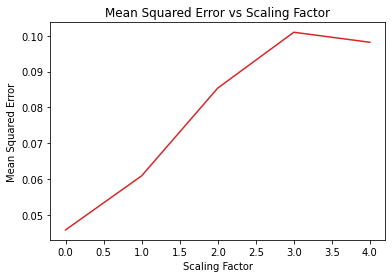

In [55]:
# plot a line graph of Mean Mean Squared Error and Mean Cross Entropy Loss
mse = [0.0458,0.0609,0.0854,0.101,0.0982]
crossentropy = [1.1603,1.21,1.28,1.32,1.32] 
Scaling_Factor = [1,1.2,1.5,2,3]
title = 'Mean Squared Error vs Scaling Factor'
plt.title(title)
plt.xlabel('Scaling Factor')
plt.ylabel('Mean Squared Error')
plt.plot(Scaling_Factor, mse, 'o-', color='#d62728', label='Mean Squared Error')
plt.show()

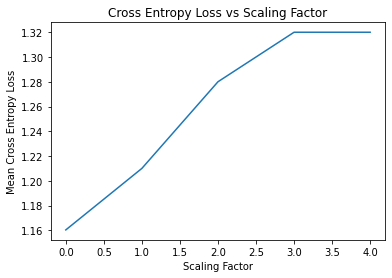

In [54]:
title = 'Cross Entropy Loss vs Scaling Factor'
plt.title(title)
plt.plot(Scaling_Factor,crossentropy, color='#1f77b4', label='Mean Cross Entropy Loss')
plt.xlabel('Scaling Factor')
plt.ylabel('Mean Cross Entropy Loss')
plt.show()

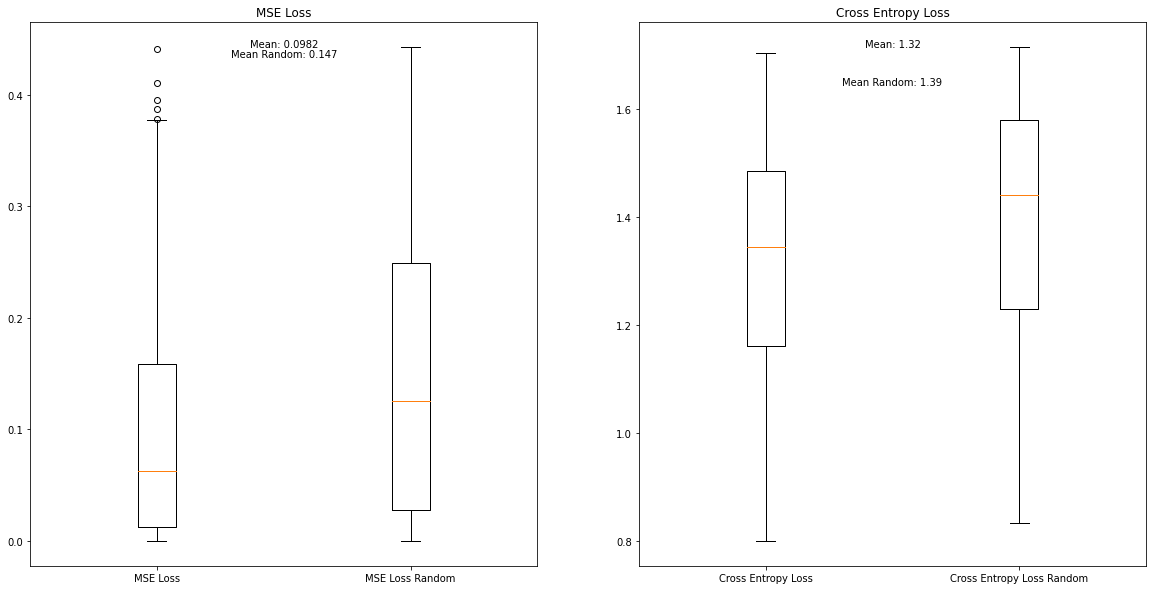

In [36]:
#
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].boxplot([mseloss, mselossrand])
axs[0].set_xticklabels(['MSE Loss', 'MSE Loss Random'])
axs[0].set_title('MSE Loss')
axs[1].boxplot([crossentropyloss, crossentropylossrand])
axs[1].set_xticklabels(['Cross Entropy Loss', 'Cross Entropy Loss Random'])
axs[1].set_title('Cross Entropy Loss')
mean = f'Mean: {np.mean(mseloss):.3g}'
meanrand = f'Mean Random: {np.mean(mselossrand):.3g}'
cross = f'Mean: {np.mean(crossentropyloss):.3g}'
crossrand = f'Mean Random: {np.mean(crossentropylossrand):.3g}'

axs[0].text(0.5, 0.95, f'{mean}', horizontalalignment='center', verticalalignment='bottom', transform=axs[0].transAxes)
axs[0].text(0.5, 0.95, f'{meanrand}', horizontalalignment='center', verticalalignment='top', transform=axs[0].transAxes)
axs[1].text(0.5, 0.95, f'{cross}', horizontalalignment='center', verticalalignment='bottom', transform=axs[1].transAxes)
axs[1].text(0.5, 0.90, f'{crossrand}', horizontalalignment='center', verticalalignment='top', transform=axs[1].transAxes)

plt.show()
